#**Protein Design and Predicting Protein-Protein Interactions**

 This Notebook is divided into 2 parts. In the first part, RFdiffusion is being used for protein designing. RoseTTAFold's architecture provides the foundation for modeling the denoising steps in diffusion. This enables RFdiffusion model to generate novel, protein structures that meet specific design criteria as accurately as possible.



 The second part of the model uses ESM-2 which is a protein language model to score pairs of proteins designed with the protein of interest which is the EGFR Protein.



**<font color="purple">*References*:</font>**  The source code for protein design can be found in [this](https://colab.research.google.com/github/sokrypton/ColabDesign/blob/main/rf/examples/diffusion.ipynb) branch and for protein-protein interactions can be found [here]( https://huggingface.co/blog/AmelieSchreiber/protein-binding-partners-with-esm2).



## **Protein Design**

In [ ]:
#@title setup **RFdiffusion**
%%time
import os, time, signal
import sys, random, string, re
if not os.path.isdir("params"):
  os.system("apt-get install aria2")
  os.system("mkdir params")
  # send param download into background
  os.system("(\
  aria2c -q -x 16 https://files.ipd.uw.edu/krypton/schedules.zip; \
  aria2c -q -x 16 http://files.ipd.uw.edu/pub/RFdiffusion/6f5902ac237024bdd0c176cb93063dc4/Base_ckpt.pt; \
  aria2c -q -x 16 http://files.ipd.uw.edu/pub/RFdiffusion/e29311f6f1bf1af907f9ef9f44b8328b/Complex_base_ckpt.pt; \
  aria2c -q -x 16 https://storage.googleapis.com/alphafold/alphafold_params_2022-12-06.tar; \
  tar -xf alphafold_params_2022-12-06.tar -C params; \
  touch params/done.txt) &")

if not os.path.isdir("RFdiffusion"):
  print("installing RFdiffusion...")
  os.system("git clone https://github.com/sokrypton/RFdiffusion.git")
  os.system("pip install jedi omegaconf hydra-core icecream pyrsistent pynvml decorator")
  os.system("pip install git+https://github.com/NVIDIA/dllogger#egg=dllogger")
  # 17Mar2024: adding --no-dependencies to avoid installing nvidia-cuda-* dependencies
  os.system("pip install --no-dependencies dgl==2.0.0 -f https://data.dgl.ai/wheels/cu121/repo.html")
  os.system("pip install --no-dependencies e3nn==0.3.3 opt_einsum_fx")
  os.system("cd RFdiffusion/env/SE3Transformer; pip install .")
  os.system("wget -qnc https://files.ipd.uw.edu/krypton/ananas")
  os.system("chmod +x ananas")

if not os.path.isdir("colabdesign"):
  print("installing ColabDesign...")
  os.system("pip -q install git+https://github.com/sokrypton/ColabDesign.git@v1.1.1")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabdesign colabdesign")

if not os.path.isdir("RFdiffusion/models"):
  print("downloading RFdiffusion params...")
  os.system("mkdir RFdiffusion/models")
  models = ["Base_ckpt.pt","Complex_base_ckpt.pt"]
  for m in models:
    while os.path.isfile(f"{m}.aria2"):
      time.sleep(5)
  os.system(f"mv {' '.join(models)} RFdiffusion/models")
  os.system("unzip schedules.zip; rm schedules.zip")

if 'RFdiffusion' not in sys.path:
  os.environ["DGLBACKEND"] = "pytorch"
  sys.path.append('RFdiffusion')

from google.colab import files
import json
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import ipywidgets as widgets
import py3Dmol

from inference.utils import parse_pdb
from colabdesign.rf.utils import get_ca
from colabdesign.rf.utils import fix_contigs, fix_partial_contigs, fix_pdb, sym_it
from colabdesign.shared.protein import pdb_to_string
from colabdesign.shared.plot import plot_pseudo_3D

def get_pdb(pdb_code=None):
  if pdb_code is None or pdb_code == "":
    upload_dict = files.upload()
    pdb_string = upload_dict[list(upload_dict.keys())[0]]
    with open("tmp.pdb","wb") as out: out.write(pdb_string)
    return "tmp.pdb"
  elif os.path.isfile(pdb_code):
    return pdb_code
  elif len(pdb_code) == 4:
    if not os.path.isfile(f"{pdb_code}.pdb1"):
      os.system(f"wget -qnc https://files.rcsb.org/download/{pdb_code}.pdb1.gz")
      os.system(f"gunzip {pdb_code}.pdb1.gz")
    return f"{pdb_code}.pdb1"
  else:
    os.system(f"wget -qnc https://alphafold.ebi.ac.uk/files/AF-{pdb_code}-F1-model_v3.pdb")
    return f"AF-{pdb_code}-F1-model_v3.pdb"

def run_ananas(pdb_str, path, sym=None):
  pdb_filename = f"outputs/{path}/ananas_input.pdb"
  out_filename = f"outputs/{path}/ananas.json"
  with open(pdb_filename,"w") as handle:
    handle.write(pdb_str)

  cmd = f"./ananas {pdb_filename} -u -j {out_filename}"
  if sym is None: os.system(cmd)
  else: os.system(f"{cmd} {sym}")

  # parse results
  try:
    out = json.loads(open(out_filename,"r").read())
    results,AU = out[0], out[-1]["AU"]
    group = AU["group"]
    chains = AU["chain names"]
    rmsd = results["Average_RMSD"]
    print(f"AnAnaS detected {group} symmetry at RMSD:{rmsd:.3}")

    C = np.array(results['transforms'][0]['CENTER'])
    A = [np.array(t["AXIS"]) for t in results['transforms']]

    # apply symmetry and filter to the asymmetric unit
    new_lines = []
    for line in pdb_str.split("\n"):
      if line.startswith("ATOM"):
        chain = line[21:22]
        if chain in chains:
          x = np.array([float(line[i:(i+8)]) for i in [30,38,46]])
          if group[0] == "c":
            x = sym_it(x,C,A[0])
          if group[0] == "d":
            x = sym_it(x,C,A[1],A[0])
          coord_str = "".join(["{:8.3f}".format(a) for a in x])
          new_lines.append(line[:30]+coord_str+line[54:])
      else:
        new_lines.append(line)
    return results, "\n".join(new_lines)

  except:
    return None, pdb_str

def run(command, steps, num_designs=1, visual="none"):

  def run_command_and_get_pid(command):
    pid_file = '/dev/shm/pid'
    os.system(f'nohup {command} > /dev/null & echo $! > {pid_file}')
    with open(pid_file, 'r') as f:
      pid = int(f.read().strip())
    os.remove(pid_file)
    return pid
  def is_process_running(pid):
    try:
      os.kill(pid, 0)
    except OSError:
      return False
    else:
      return True

  run_output = widgets.Output()
  progress = widgets.FloatProgress(min=0, max=1, description='running', bar_style='info')
  display(widgets.VBox([progress, run_output]))

  # clear previous run
  for n in range(steps):
    if os.path.isfile(f"/dev/shm/{n}.pdb"):
      os.remove(f"/dev/shm/{n}.pdb")

  pid = run_command_and_get_pid(command)
  try:
    fail = False
    for _ in range(num_designs):

      # for each step check if output generated
      for n in range(steps):
        wait = True
        while wait and not fail:
          time.sleep(0.1)
          if os.path.isfile(f"/dev/shm/{n}.pdb"):
            pdb_str = open(f"/dev/shm/{n}.pdb").read()
            if pdb_str[-3:] == "TER":
              wait = False
            elif not is_process_running(pid):
              fail = True
          elif not is_process_running(pid):
            fail = True

        if fail:
          progress.bar_style = 'danger'
          progress.description = "failed"
          break

        else:
          progress.value = (n+1) / steps
          if visual != "none":
            with run_output:
              run_output.clear_output(wait=True)
              if visual == "image":
                xyz, bfact = get_ca(f"/dev/shm/{n}.pdb", get_bfact=True)
                fig = plt.figure()
                fig.set_dpi(100);fig.set_figwidth(6);fig.set_figheight(6)
                ax1 = fig.add_subplot(111);ax1.set_xticks([]);ax1.set_yticks([])
                plot_pseudo_3D(xyz, c=bfact, cmin=0.5, cmax=0.9, ax=ax1)
                plt.show()
              if visual == "interactive":
                view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
                view.addModel(pdb_str,'pdb')
                view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':0.5,'max':0.9}}})
                view.zoomTo()
                view.show()
        if os.path.exists(f"/dev/shm/{n}.pdb"):
          os.remove(f"/dev/shm/{n}.pdb")
      if fail:
        progress.bar_style = 'danger'
        progress.description = "failed"
        break

    while is_process_running(pid):
      time.sleep(0.1)

  except KeyboardInterrupt:
    os.kill(pid, signal.SIGTERM)
    progress.bar_style = 'danger'
    progress.description = "stopped"

def run_diffusion(contigs, path, pdb=None, iterations=50,
                  symmetry="none", order=1, hotspot=None,
                  chains=None, add_potential=False,
                  num_designs=1, visual="none"):

  full_path = f"outputs/{path}"
  os.makedirs(full_path, exist_ok=True)
  opts = [f"inference.output_prefix={full_path}",
          f"inference.num_designs={num_designs}"]

  if chains == "": chains = None

  # determine symmetry type
  if symmetry in ["auto","cyclic","dihedral"]:
    if symmetry == "auto":
      sym, copies = None, 1
    else:
      sym, copies = {"cyclic":(f"c{order}",order),
                     "dihedral":(f"d{order}",order*2)}[symmetry]
  else:
    symmetry = None
    sym, copies = None, 1

  # determine mode
  contigs = contigs.replace(","," ").replace(":"," ").split()
  is_fixed, is_free = False, False
  fixed_chains = []
  for contig in contigs:
    for x in contig.split("/"):
      a = x.split("-")[0]
      if a[0].isalpha():
        is_fixed = True
        if a[0] not in fixed_chains:
          fixed_chains.append(a[0])
      if a.isnumeric():
        is_free = True
  if len(contigs) == 0 or not is_free:
    mode = "partial"
  elif is_fixed:
    mode = "fixed"
  else:
    mode = "free"

  # fix input contigs
  if mode in ["partial","fixed"]:
    pdb_str = pdb_to_string(get_pdb(pdb), chains=chains)
    if symmetry == "auto":
      a, pdb_str = run_ananas(pdb_str, path)
      if a is None:
        print(f'ERROR: no symmetry detected')
        symmetry = None
        sym, copies = None, 1
      else:
        if a["group"][0] == "c":
          symmetry = "cyclic"
          sym, copies = a["group"], int(a["group"][1:])
        elif a["group"][0] == "d":
          symmetry = "dihedral"
          sym, copies = a["group"], 2 * int(a["group"][1:])
        else:
          print(f'ERROR: the detected symmetry ({a["group"]}) not currently supported')
          symmetry = None
          sym, copies = None, 1

    elif mode == "fixed":
      pdb_str = pdb_to_string(pdb_str, chains=fixed_chains)

    pdb_filename = f"{full_path}/input.pdb"
    with open(pdb_filename, "w") as handle:
      handle.write(pdb_str)

    parsed_pdb = parse_pdb(pdb_filename)
    opts.append(f"inference.input_pdb={pdb_filename}")
    if mode in ["partial"]:
      iterations = int(80 * (iterations / 200))
      opts.append(f"diffuser.partial_T={iterations}")
      contigs = fix_partial_contigs(contigs, parsed_pdb)
    else:
      opts.append(f"diffuser.T={iterations}")
      contigs = fix_contigs(contigs, parsed_pdb)
  else:
    opts.append(f"diffuser.T={iterations}")
    parsed_pdb = None
    contigs = fix_contigs(contigs, parsed_pdb)

  if hotspot is not None and hotspot != "":
    opts.append(f"ppi.hotspot_res=[{hotspot}]")

  # setup symmetry
  if sym is not None:
    sym_opts = ["--config-name symmetry", f"inference.symmetry={sym}"]
    if add_potential:
      sym_opts += ["'potentials.guiding_potentials=[\"type:olig_contacts,weight_intra:1,weight_inter:0.1\"]'",
                   "potentials.olig_intra_all=True","potentials.olig_inter_all=True",
                   "potentials.guide_scale=2","potentials.guide_decay=quadratic"]
    opts = sym_opts + opts
    contigs = sum([contigs] * copies,[])

  opts.append(f"'contigmap.contigs=[{' '.join(contigs)}]'")
  opts += ["inference.dump_pdb=True","inference.dump_pdb_path='/dev/shm'"]

  print("mode:", mode)
  print("output:", full_path)
  print("contigs:", contigs)

  opts_str = " ".join(opts)
  cmd = f"./RFdiffusion/run_inference.py {opts_str}"
  print(cmd)

  # RUN
  run(cmd, iterations, num_designs, visual=visual)

  # fix pdbs
  for n in range(num_designs):
    pdbs = [f"outputs/traj/{path}_{n}_pX0_traj.pdb",
            f"outputs/traj/{path}_{n}_Xt-1_traj.pdb",
            f"{full_path}_{n}.pdb"]
    for pdb in pdbs:
      with open(pdb,"r") as handle: pdb_str = handle.read()
      with open(pdb,"w") as handle: handle.write(fix_pdb(pdb_str, contigs))

  return contigs, copies

installing RFdiffusion...
installing ColabDesign...
downloading RFdiffusion params...


/usr/local/lib/python3.10/dist-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.d

CPU times: user 9.07 s, sys: 1.11 s, total: 10.2 s
Wall time: 2min 43s


In [ ]:
%%time
#@title run **RFdiffusion** to generate a backbone
name = "EGFRReceptor" #@param {type:"string"}
contigs = "A11-13/A15-18/A356/A440-441:100-250" #@param {type:"string"}
pdb = "6ARU" #@param {type:"string"}
iterations = 50 #@param ["25", "50", "100", "150", "200"] {type:"raw"}
hotspot = "" #@param {type:"string"}
num_designs = 8 #@param ["1", "2", "4", "8", "16", "32"] {type:"raw"}
visual = "none" #@param ["none", "image", "interactive"]
#@markdown ---
#@markdown **symmetry** settings
#@markdown ---
symmetry = "none" #@param ["none", "auto", "cyclic", "dihedral"]
order = 1 #@param ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"] {type:"raw"}
chains = "" #@param {type:"string"}
add_potential = True #@param {type:"boolean"}
#@markdown - `symmetry='auto'` enables automatic symmetry dectection with [AnAnaS](https://team.inria.fr/nano-d/software/ananas/).
#@markdown - `chains="A,B"` filter PDB input to these chains (may help auto-symm detector)
#@markdown - `add_potential` to discourage clashes between chains

# determine where to save
path = name
while os.path.exists(f"outputs/{path}_0.pdb"):
  path = name + "_" + ''.join(random.choices(string.ascii_lowercase + string.digits, k=5))

flags = {"contigs":contigs,
         "pdb":pdb,
         "order":order,
         "iterations":iterations,
         "symmetry":symmetry,
         "hotspot":hotspot,
         "path":path,
         "chains":chains,
         "add_potential":add_potential,
         "num_designs":num_designs,
         "visual":visual}

for k,v in flags.items():
  if isinstance(v,str):
    flags[k] = v.replace("'","").replace('"','')

contigs, copies = run_diffusion(**flags)

mode: fixed
output: outputs/EGFR_Receptor
contigs: ['A11-13/A15-18/A356-356/A440-441', '233-233']
./RFdiffusion/run_inference.py inference.output_prefix=outputs/EGFR_Receptor inference.num_designs=8 inference.input_pdb=outputs/EGFR_Receptor/input.pdb diffuser.T=50 'contigmap.contigs=[A11-13/A15-18/A356-356/A440-441 233-233]' inference.dump_pdb=True inference.dump_pdb_path='/dev/shm'


CPU times: user 5.74 s, sys: 883 ms, total: 6.62 s
Wall time: 21min 2s


In [ ]:
#@title Display 3D structure {run: "auto"}
animate = "none" #@param ["none", "movie", "interactive"]
color = "chain" #@param ["rainbow", "chain", "plddt"]
denoise = True
dpi = 100 #@param ["100", "200", "400"] {type:"raw"}
from colabdesign.shared.plot import pymol_color_list
from colabdesign.rf.utils import get_ca, get_Ls, make_animation
from string import ascii_uppercase,ascii_lowercase
alphabet_list = list(ascii_uppercase+ascii_lowercase)

def plot_pdb(num=0):
  if denoise:
    pdb_traj = f"outputs/traj/{path}_{num}_pX0_traj.pdb"
  else:
    pdb_traj = f"outputs/traj/{path}_{num}_Xt-1_traj.pdb"
  if animate in ["none","interactive"]:
    hbondCutoff = 4.0
    view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
    if animate == "interactive":
      pdb_str = open(pdb_traj,'r').read()
      view.addModelsAsFrames(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
    else:
      pdb = f"outputs/{path}_{num}.pdb"
      pdb_str = open(pdb,'r').read()
      view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
    if color == "rainbow":
      view.setStyle({'cartoon': {'color':'spectrum'}})
    elif color == "chain":
      for n,chain,c in zip(range(len(contigs)),
                              alphabet_list,
                              pymol_color_list):
          view.setStyle({'chain':chain},{'cartoon': {'color':c}})
    else:
      view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':0.5,'max':0.9}}})
    view.zoomTo()
    if animate == "interactive":
      view.animate({'loop': 'backAndForth'})
    view.show()
  else:
    Ls = get_Ls(contigs)
    xyz, bfact = get_ca(pdb_traj, get_bfact=True)
    xyz = xyz.reshape((-1,sum(Ls),3))[::-1]
    bfact = bfact.reshape((-1,sum(Ls)))[::-1]
    if color == "chain":
      display(HTML(make_animation(xyz, Ls=Ls, dpi=dpi, ref=-1)))
    elif color == "rainbow":
      display(HTML(make_animation(xyz, dpi=dpi, ref=-1)))
    else:
      display(HTML(make_animation(xyz, plddt=bfact*100, dpi=dpi, ref=-1)))


if num_designs > 1:
  output = widgets.Output()
  def on_change(change):
    if change['name'] == 'value':
      with output:
        output.clear_output(wait=True)
        plot_pdb(change['new'])
  dropdown = widgets.Dropdown(
      options=[(f'{k}',k) for k in range(num_designs)],
      value=0, description='design:',
  )
  dropdown.observe(on_change)
  display(widgets.VBox([dropdown, output]))
  with output:
    plot_pdb(dropdown.value)
else:
  plot_pdb()

In [ ]:
%%time
#@title run **ProteinMPNN** to generate a sequence and **AlphaFold** to validate
num_seqs = 16 #@param ["1", "2", "4", "8", "16", "32", "64"] {type:"raw"}
initial_guess = True #@param {type:"boolean"}
num_recycles = 3 #@param ["0", "1", "2", "3", "6", "12"] {type:"raw"}
use_multimer = False #@param {type:"boolean"}
rm_aa = "C" #@param {type:"string"}
mpnn_sampling_temp = 0.2 #@param ["0.0001", "0.1", "0.15", "0.2", "0.25", "0.3", "0.5", "1.0"] {type:"raw"}
#@markdown - for **binder** design, we recommend `initial_guess=True num_recycles=3`

if not os.path.isfile("params/done.txt"):
  print("downloading AlphaFold params...")
  while not os.path.isfile("params/done.txt"):
    time.sleep(5)

contigs_str = ":".join(contigs)
opts = [f"--pdb=outputs/{path}_0.pdb",
        f"--loc=outputs/{path}",
        f"--contig={contigs_str}",
        f"--copies={copies}",
        f"--num_seqs={num_seqs}",
        f"--num_recycles={num_recycles}",
        f"--rm_aa={rm_aa}",
        f"--mpnn_sampling_temp={mpnn_sampling_temp}",
        f"--num_designs={num_designs}"]
if initial_guess: opts.append("--initial_guess")
if use_multimer: opts.append("--use_multimer")
opts = ' '.join(opts)
!python colabdesign/rf/designability_test.py {opts}

{'pdb':'outputs/EGFR_Receptor_0.pdb','loc':'outputs/EGFR_Receptor','contigs':'A11-13/A15-18/A356-356/A440-441:233-233','copies':1,'num_seqs':16,'initial_guess':True,'use_multimer':False,'num_recycles':3,'rm_aa':'C','num_designs':8,'mpnn_sampling_temp':0.2}
protocol=binder
2024-10-30 19:48:55.007543: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
running proteinMPNN...
running AlphaFold...
design:0 n:0 mpnn:1.028 plddt:0.692 i_ptm:0.125 i_pae:27.399 rmsd:61.353 SNKTQLGSSG/ATHTLTLTIDVTEIAGVKLKVTITLTPDKVTFKVEVEDDSEVEVEEKVTPDSYVLTATVLKDGIQIVAVLVLQKKGSAVVSITLTAKEGVTTVIISIRAEQLDASASSTLNVTVNAPTVKVLGIMATTLGKTRLTLTIDANADAKINIIMNGDTAEAVASLRENAAALKAKFPDLELVEVDVPEGYSQEE

In [ ]:
#@title Display best result
import py3Dmol
def plot_pdb(num = "best"):
  if num == "best":
    with open(f"outputs/{path}/best.pdb","r") as f:
      # REMARK 001 design {m} N {n} RMSD {rmsd}
      info = f.readline().strip('\n').split()
    num = info[3]
  hbondCutoff = 4.0
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
  pdb_str = open(f"outputs/{path}_{num}.pdb",'r').read()
  view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  pdb_str = open(f"outputs/{path}/best_design{num}.pdb",'r').read()
  view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})

  view.setStyle({"model":0},{'cartoon':{}}) #: {'colorscheme': {'prop':'b','gradient': 'roygb','min':0,'max':100}}})
  view.setStyle({"model":1},{'cartoon':{'colorscheme': {'prop':'b','gradient': 'roygb','min':0,'max':100}}})
  view.zoomTo()
  view.show()

if num_designs > 1:
  def on_change(change):
    if change['name'] == 'value':
      with output:
        output.clear_output(wait=True)
        plot_pdb(change['new'])
  dropdown = widgets.Dropdown(
    options=["best"] + [str(k) for k in range(num_designs)],
    value="best",
    description='design:',
  )
  dropdown.observe(on_change)
  output = widgets.Output()
  display(widgets.VBox([dropdown, output]))
  with output:
    plot_pdb(dropdown.value)
else:
  plot_pdb()

In [ ]:
#@title Package and download results
#@markdown If you are having issues downloading the result archive,
#@markdown try disabling your adblocker and run this cell again.
#@markdown  If that fails click on the little folder icon to the
#@markdown  left, navigate to file: `name.result.zip`,
#@markdown  right-click and select \"Download\"
#@markdown (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).
!zip -r {path}.result.zip outputs/{path}* outputs/traj/{path}*
files.download(f"{path}.result.zip")

  adding: outputs/EGFR_Receptor/ (stored 0%)
  adding: outputs/EGFR_Receptor/mpnn_results.csv (deflated 52%)
  adding: outputs/EGFR_Receptor/all_pdb/ (stored 0%)
  adding: outputs/EGFR_Receptor/all_pdb/design3_n5.pdb (deflated 77%)
  adding: outputs/EGFR_Receptor/all_pdb/design2_n15.pdb (deflated 78%)
  adding: outputs/EGFR_Receptor/all_pdb/design4_n15.pdb (deflated 78%)
  adding: outputs/EGFR_Receptor/all_pdb/design3_n12.pdb (deflated 77%)
  adding: outputs/EGFR_Receptor/all_pdb/design5_n14.pdb (deflated 78%)
  adding: outputs/EGFR_Receptor/all_pdb/design2_n8.pdb (deflated 78%)
  adding: outputs/EGFR_Receptor/all_pdb/design4_n3.pdb (deflated 78%)
  adding: outputs/EGFR_Receptor/all_pdb/design2_n14.pdb (deflated 77%)
  adding: outputs/EGFR_Receptor/all_pdb/design7_n9.pdb (deflated 77%)
  adding: outputs/EGFR_Receptor/all_pdb/design0_n14.pdb (deflated 78%)
  adding: outputs/EGFR_Receptor/all_pdb/design3_n14.pdb (deflated 78%)
  adding: outputs/EGFR_Receptor/all_pdb/design7_n2.pdb (defla

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Clarifications**
---
---

`contigs` was used to define continious chains. Used a `:` to define multiple contigs and a `/` to define mutliple segments within a contig.
For example:
**binder design**
- `contigs='E6-155:70-100'` `pdb='5KQV'` `hotspot='E64,E88,E96'` - diffuse a **binder** of length 70 to 100 (sampled randomly) to chain E and defined hotspot(s).


##**Protein-Protein Interactions**

In [ ]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from transformers import AutoTokenizer, EsmForMaskedLM
import torch

### Initializing ESM-2 model built for protein sequences and tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = EsmForMaskedLM.from_pretrained("facebook/esm2_t6_8M_UR50D")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/31.4M [00:00<?, ?B/s]

### Adding all the protein binders to a list

In [4]:
import pandas as pd


protein_data = pd.read_csv("/content/outputs/EGFR_Receptor/mpnn_results.csv")

potential_binders = protein_data["seq"].tolist()

print(potential_binders)


['SNKTQLGSSG/ATHTLTLTIDVTEIAGVKLKVTITLTPDKVTFKVEVEDDSEVEVEEKVTPDSYVLTATVLKDGIQIVAVLVLQKKGSAVVSITLTAKEGVTTVIISIRAEQLDASASSTLNVTVNAPTVKVLGIMATTLGKTRLTLTIDANADAKINIIMNGDTAEAVASLRENAAALKAKFPDLELVEVDVPEGYSQEEFEKLKEELLKISNLVLVISGEVPDEKLNELLNALLLKQIKELE', 'SNKTQLGSSG/AEYELELEVDLSEIAGVKLRVKIKISDDEVEFEVEVKDDVEVEVEIEETPDTYVLRATVIKDGIQIVAVAVVMLKSDAKVDLTIEAKEGVTHLHIYLKAKQIDKDGTSTLNVTINAKSVKVLSIGIIAEGKVKVNLTLNINDDTKVNIIMNGDTKEAIENLKKNAEELKKKIPDLKLVYVDLPEGYSEEEFEKLIEELKKIENLILVLSGKVPSEKLNEMLNALTLEQLKKLK', 'SNKTQLGSSG/TTETLELNIDVTEIAGVELKVKVTITDDKVTFEVEVKDDVEVEVEETVTPDSYVLKVTVLRDGIQIVAIVVVLKKGNSKVNINLTAPKGVKIMIISIKVKQLDSSSSSTVNININAEDVEVLSISISLEGKVKVNLTINANKNTKINIVMNATTPEAIQSVKENAKNIVKKFPNLKLREVSVPEGFSQEEYDKLKEEFLKEDNLVLVIDGEVPDSLLNDLLLALTKKQLEKLK', 'SNKTQLGSSG/MTHEVELEVDLSEIAGIKLKVKIILTENEIKVEVTVEDDIEVEVKVEITPDSVVVTATALKDGIQIVAIAVLQRRADSRVEISIETKKGVKIAIIDIVAEQLDPEGTSELNIHINAPDVEVLGIRIELRGNVRVKLTIDANPDTVINIIMNADTPLAVESVRENAKELKKKFPKLKLVEVELPEGFTEEELKKLIEELLKIDNLILVISGTVPGSKLNEILNKLLLKQLKKLE', 'SNKTQL

In [5]:
protein_of_interest= 'LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYVQRNYDLSFLKTIQEVAGYVLIALNTVERIPLENLQIIRGNMYYENSYALAVLSNYDANKTGLKELPMRNLQEILHGAVRFSNNPALCNVESIQWRDIVSSDFLSNMSMDFQNHLGSCQKCDPSCPNGSCWGAGEENCQKLTKIICAQQCSGRCRGKSPSDCCHNQCAAGCTGPRESDCLVCRKFRDEATCKDTCPPLMLYNPTTYQMDVNPEGKYSFGATCVKKCPRNYVVTDHGSCVRACGADSYEMEEDGVRKCKKCEGPCRKVCNGIGIGEFKDSLSINATNIKHFKNCTSISGDLHILPVAFRGDSFTHTPPLDPQELDILKTVKEITGFLLIQAWPENRTDLHAFENLEIIRGRTKQHGQFSLAVVSLNITSLGLRSLKEISDGDVIISGNKNLCYANTINWKKLFGTSGQKTKIISNRGENSCKATGQVCHALCSPEGCWGPEPRDCVSCRNVSRGRECVDKCNLLEGEPREFVENSECIQCHPECLPQAMNITCTGRGPDNCIQCAHYIDGPHCVKTCPAGVMGENNTLVWKYADAGHVCHLCHPNCTYGCTGPGLEGCPTNGPKIPS'

In [6]:
from transformers import AutoModelForMaskedLM, AutoTokenizer
import torch

# Load the base model and tokenizer
base_model_path = "facebook/esm2_t12_35M_UR50D"
model = AutoModelForMaskedLM.from_pretrained(base_model_path)
tokenizer = AutoTokenizer.from_pretrained(base_model_path)

# Ensure the model is in evaluation mode
model.eval()

def compute_mlm_loss(protein, binder, iterations=3):
    total_loss = 0.0

    for _ in range(iterations):
        # Concatenate protein sequences with a separator
        concatenated_sequence = protein + ":" + binder

        # Mask a subset of amino acids in the concatenated sequence (excluding the separator)
        tokens = list(concatenated_sequence)
        mask_rate = 0.15
        num_mask = int(len(tokens) * mask_rate)

        # Exclude the separator from potential mask indices
        available_indices = [i for i, token in enumerate(tokens) if token != ":"]
        probs = torch.ones(len(available_indices))
        mask_indices = torch.multinomial(probs, num_mask, replacement=False)

        for idx in mask_indices:
            tokens[available_indices[idx]] = tokenizer.mask_token

        masked_sequence = "".join(tokens)
        inputs = tokenizer(masked_sequence, return_tensors="pt", truncation=True, max_length=1024, padding='max_length')

        # Compute the MLM loss
        with torch.no_grad():
            outputs = model(**inputs, labels=inputs["input_ids"])
            loss = outputs.loss

        total_loss += loss.item()

    # Return the average loss
    return total_loss / iterations

# Compute MLM loss for each potential binder
mlm_losses = {}
for binder in potential_binders:
    loss = compute_mlm_loss(protein_of_interest, binder)
    mlm_losses[binder] = loss

# Rank binders based on MLM loss
ranked_binders = sorted(mlm_losses, key=mlm_losses.get)

print("Ranking of Potential Binders:")
for idx, binder in enumerate(ranked_binders, 1):
    print(f"{idx}. {binder} - MLM Loss: {mlm_losses[binder]}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/778 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/136M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Ranking of Potential Binders:
1. SNKTQLGSSG/LPLEEILAREEAEREAEEKEKFEKLAKEFEELKGIVFIITSEDEKEKAEKLIEKLKNAKEIYYEEIKIIDGYVDIESLKEAFEKIIKKLDSIKEKVDIAIAIFLTIDLSKLSKEERKKVSKEFISTFVDELEKLIEKALKKTSNTLIIYIDIDDVTVEEAKELLEKTTDAIIKVLKKIKSKAKVKVYIDIDVKNVKDEAEVEELKKTAEEAKKRLKEAGVEEVEIDVDVEVVP - MLM Loss: 6.66111962000529
2. SNKTQLGSSG/ETIKKEIKLPNIDIEIEVKKKKGYVEITIKIKNTGITIKIKIKDGDKVKINIKTIKKEGGKATITTININIKYENGKIEIEINASTEEKPADEELTEIKIEIESKDGNIKIKIEIKNTSKKDVNINIDINIDKANAKLDIDLKLTNNNGNLNVNINVNTNAKGAEVNINVEIKASEGATVNVNINSNSPNTKITINYNGKKYIIESSGKVKVKVKDGEIEIEAENVTKIEEIK - MLM Loss: 6.704061985015869
3. SNKTQLGSSG/SEEEMKETLKNTEYTVEINVEELPDGTIVVTIKIYKKVNGKEELVAEITVTLKLTKENGVLYGEGSATAFSPDGTAVAVSVVYIKRPGQEFLLVVILVAEVFNPKSKVVSVKLETEVEIEGNKVKVNITATVTVSAEAKDGEYFFLRVVLHVQLHPSVKVKERKFKIKKIEVKVETENADAKVELVEEEVEVEESENSIKITLDIKLKAIGDAKFTLTVKIETELTLELDVPL - MLM Loss: 6.706818421681722
4. SNKTQLGSSG/MSPEERAEREREERERREAERLERLAKELEELAGLVFIIHSEAMAEKAKEIKEKLTKAKKIVERTVKVVDGAPDLESLKEAFEEVIKELEEQKEKVDIAIIVLLTIDLSSLDPETAKELSEKF

### Building a PPI Network

In [3]:
!unzip /content/EGFR_Receptor.result.zip

Archive:  /content/EGFR_Receptor.result.zip
replace outputs/EGFR_Receptor/mpnn_results.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import networkx as nx
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM
import plotly.graph_objects as go
from ipywidgets import interact
from ipywidgets import widgets

In [ ]:
# Check if CUDA is available and set the default device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pretrained (or fine-tuned) ESM-2 model and tokenizer
model_name = "facebook/esm2_t6_8M_UR50D"  # You can change this to your fine-tuned model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForMaskedLM.from_pretrained(model_name)

# Send the model to the device (GPU or CPU)
model.to(device)

# Ensure the model is in evaluation mode
model.eval()


all_proteins = [

def compute_average_mlm_loss(protein1, protein2, iterations=10):
    total_loss = 0.0
    connector = "G" * 25  # Connector sequence of G's
    for _ in range(iterations):
        concatenated_sequence = protein1 + connector + protein2
        inputs = tokenizer(concatenated_sequence, return_tensors="pt", padding=True, truncation=True, max_length=1024)

        mask_prob = 0.55
        mask_indices = torch.rand(inputs["input_ids"].shape, device=device) < mask_prob

        # Locate the positions of the connector 'G's and set their mask indices to False
        connector_indices = tokenizer.encode(connector, add_special_tokens=False)
        connector_length = len(connector_indices)
        start_connector = len(tokenizer.encode(protein1, add_special_tokens=False))
        end_connector = start_connector + connector_length

        # Avoid masking the connector 'G's
        mask_indices[0, start_connector:end_connector] = False

        # Apply the mask to the input IDs
        inputs["input_ids"][mask_indices] = tokenizer.mask_token_id
        inputs = {k: v.to(device) for k, v in inputs.items()}  # Send inputs to the device

        with torch.no_grad():
            outputs = model(**inputs, labels=inputs["input_ids"])

        loss = outputs.loss
        total_loss += loss.item()

    return total_loss / iterations

# Compute all average losses to determine the maximum threshold for the slider
all_losses = []
for i, protein1 in enumerate(all_proteins):
    for j, protein2 in enumerate(all_proteins[i+1:], start=i+1):
        avg_loss = compute_average_mlm_loss(protein1, protein2)
        all_losses.append(avg_loss)

# Set the maximum threshold to the maximum loss computed
max_threshold = max(all_losses)
print(f"Maximum loss (maximum threshold for slider): {max_threshold}")

def plot_graph(threshold):
    G = nx.Graph()

    # Add all protein nodes to the graph
    for i, protein in enumerate(all_proteins):
        G.add_node(f"protein {i+1}")

    # Loop through all pairs of proteins and calculate average MLM loss
    loss_idx = 0  # Index to keep track of the position in the all_losses list
    for i, protein1 in enumerate(all_proteins):
        for j, protein2 in enumerate(all_proteins[i+1:], start=i+1):
            avg_loss = all_losses[loss_idx]
            loss_idx += 1

            # Add an edge if the loss is below the threshold
            if avg_loss < threshold:
                G.add_edge(f"protein {i+1}", f"protein {j+1}", weight=round(avg_loss, 3))

    # 3D Network Plot
    # Adjust the k parameter to bring nodes closer. This might require some experimentation to find the right value.
    k_value = 2  # Lower value will bring nodes closer together
    pos = nx.spring_layout(G, dim=3, seed=42, k=k_value)

    edge_x = []
    edge_y = []
    edge_z = []
    for edge in G.edges():
        x0, y0, z0 = pos[edge[0]]
        x1, y1, z1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
        edge_z.extend([z0, z1, None])

    edge_trace = go.Scatter3d(x=edge_x, y=edge_y, z=edge_z, mode='lines', line=dict(width=0.5, color='grey'))

    node_x = []
    node_y = []
    node_z = []
    node_text = []
    for node in G.nodes():
        x, y, z = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_z.append(z)
        node_text.append(node)

    node_trace = go.Scatter3d(x=node_x, y=node_y, z=node_z, mode='markers', marker=dict(size=5), hoverinfo='text', hovertext=node_text)

    layout = go.Layout(title='Protein Interaction Graph', title_x=0.5, scene=dict(xaxis=dict(showbackground=False), yaxis=dict(showbackground=False), zaxis=dict(showbackground=False)))

    fig = go.Figure(data=[edge_trace, node_trace], layout=layout)
    fig.show()

# Create an interactive slider for the threshold value with a default of 8.50
interact(plot_graph, threshold=widgets.FloatSlider(min=0.0, max=max_threshold, step=0.05, value=8.25))


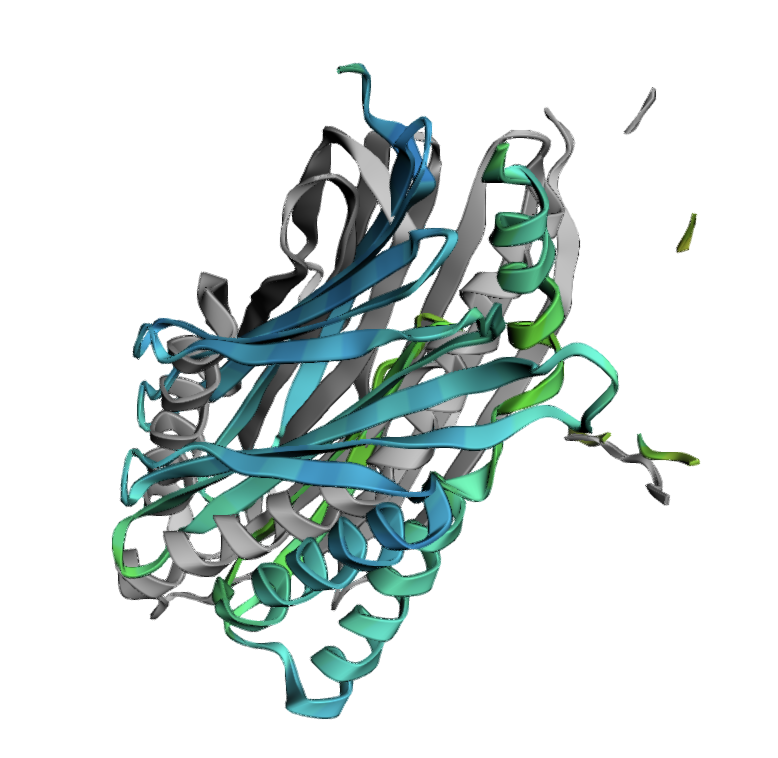

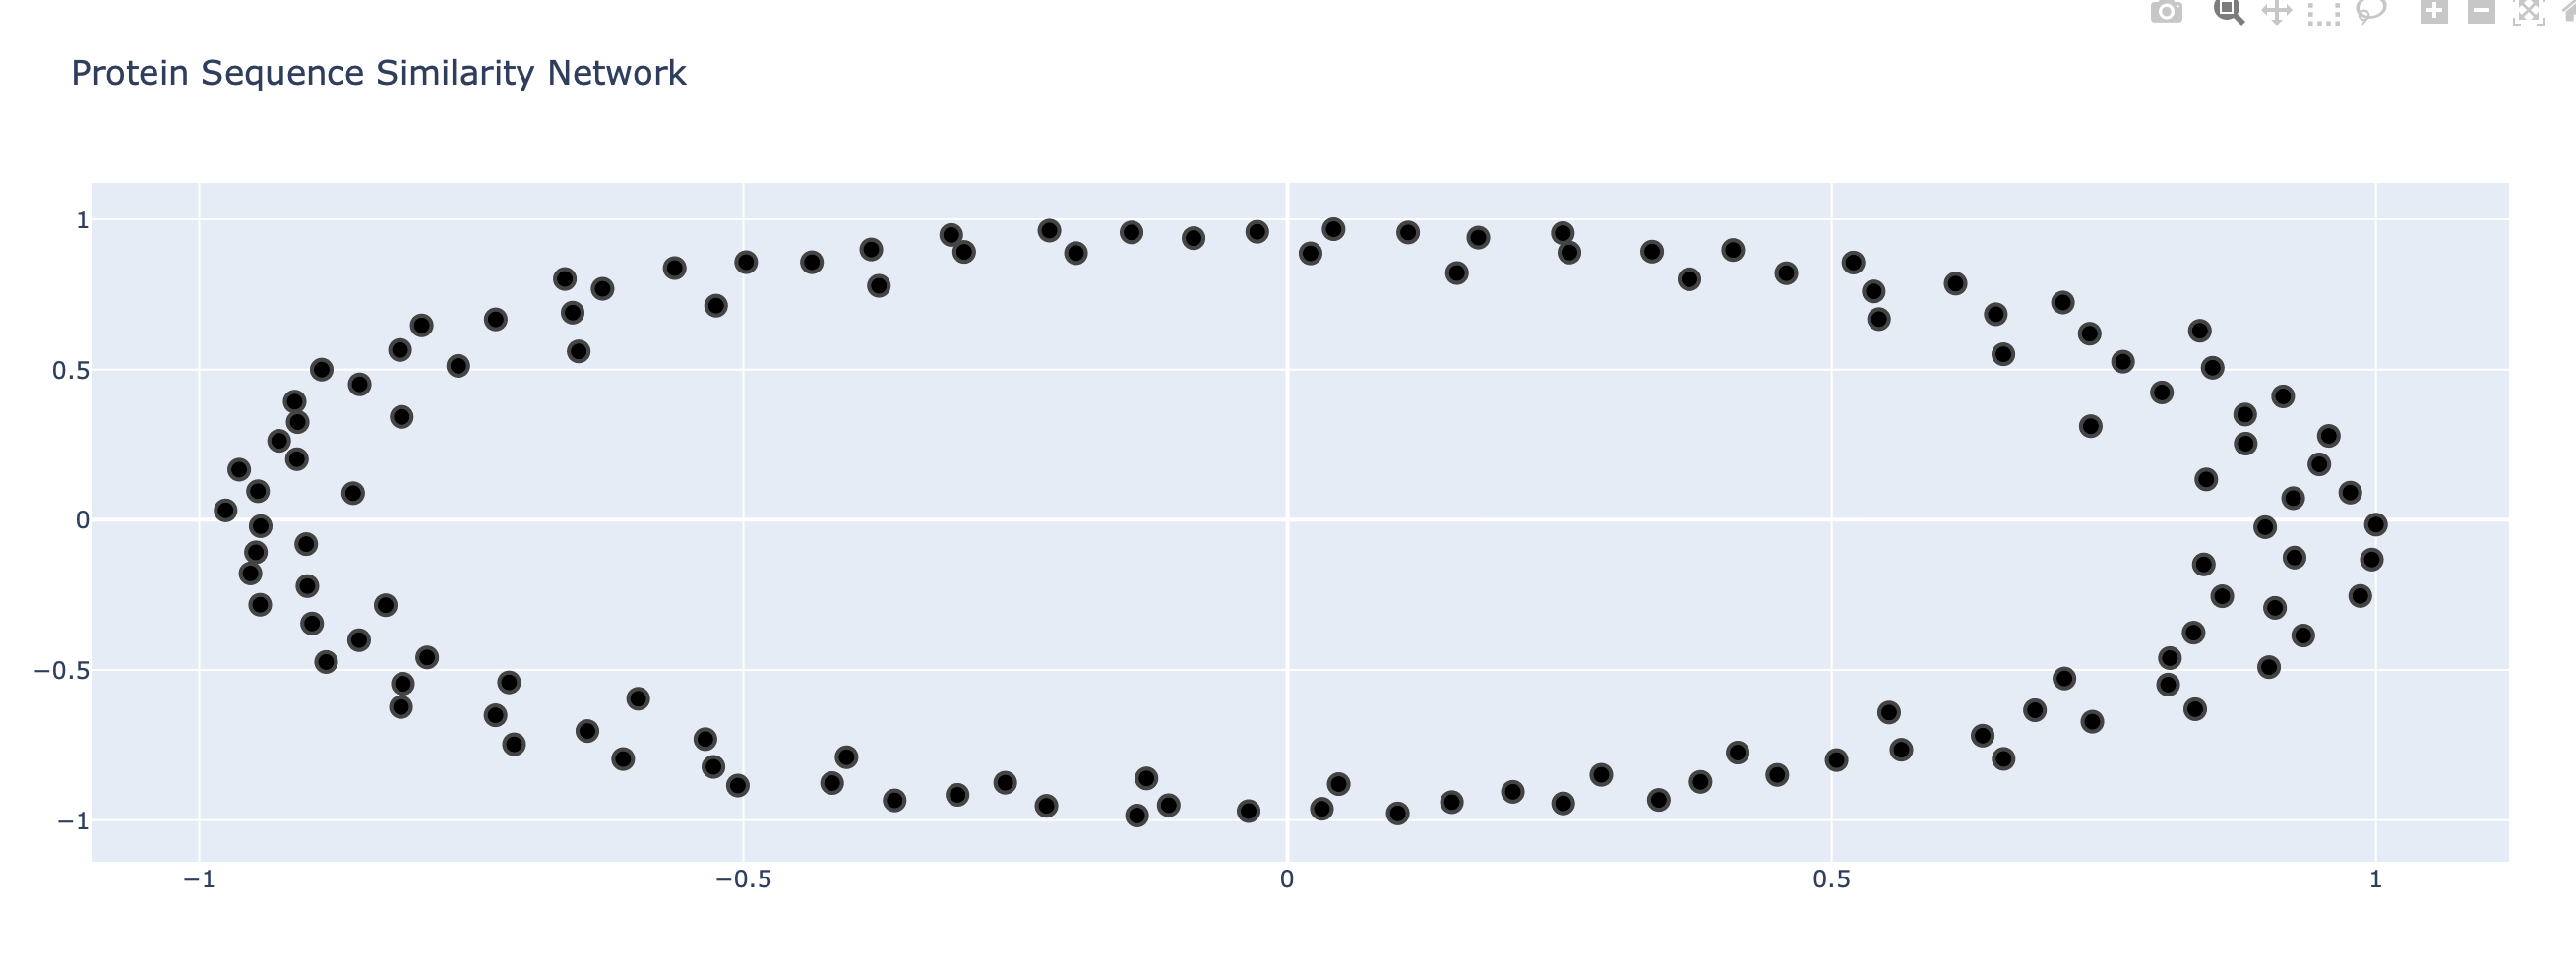

SNKTQLGSSG/LPLEEILAREEAEREAEEKEKFEKLAKEFEELKGIVFIITSEDEKEKAEKLIEKLKNAKEIYYEEIKIIDGYVDIESLKEAFEKIIKKLDSIKEKVDIAIAIFLTIDLSKLSKEERKKVSKEFISTFVDELEKLIEKALKKTSNTLIIYIDIDDVTVEEAKELLEKTTDAIIKVLKKIKSKAKVKVYIDIDVKNVKDEAEVEELKKTAEEAKKRLKEAGVEEVEIDVDVEVVP - MLM Loss: 6.66111962000529 Is the best model based on the parameters set and protein-protein interactions calculated with the binder of interest.